Import Necessary Libraries

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize

Creating Unet Architecture Based on Imagenet Trained Resnet50 Encoder Block

In [13]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #next block
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


In [14]:
def decoder_block(inputs, skip_features, num_filters):

    #first layer of each decoder block is a 2D-Conv transpose layer of shape 2,2
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(inputs)
    x = Concatenate()([x,skip_features])
    x = conv_block(x, num_filters)
    return x

In [15]:
def build_resnet50_unet(input_shape):
    #creating the input layer
    inputs =  Input(input_shape, name='input_1')

    #calling the pretrained resnet50 model
    resnet50 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    #set the resnet model to inference mode (we can also train the layers of resnet except the BatchNorm without destroying the learned pattern)
    resnet50.trainable = False

    #summary of the resnet
    #resnet50.summary()

    #creating the encoder block with renset (branching out the skip connections for later use in decoder)
    s1 = resnet50.get_layer('input_1').output   #512
    s2 = resnet50.get_layer('conv1_relu').output    #256
    s3 = resnet50.get_layer('conv2_block3_out').output  #128
    s4 = resnet50.get_layer('conv3_block4_out').output  #64

    #bride connection between the encoder and decoder
    b1 = resnet50.get_layer('conv4_block4_out').output  #32
    
    #creating the decoder part
    d1 =  decoder_block(b1, s4, 512)        #64
    d2 =  decoder_block(d1, s3, 256)        #128
    d3 =  decoder_block(d2, s2, 128)        #256
    d4 =  decoder_block(d3, s1, 64)         #512,512, 1

    #output layer
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

    model = model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

    # check for the shapes

### Data Processing and Ready for training

In [16]:
import numpy as np
import os
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU
import platform
from sklearn.model_selection import train_test_split as tts

image_size = 224

Load Images

In [17]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

In [18]:
root_path = './Dataset_BUSI_with_GT/'
classes = sorted(os.listdir(root_path))
classes = classes[1:]
classes

['benign', 'malignant', 'normal']

In [28]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

#create a df of paths ands masks
ipdict = {'images':image_paths, 'masks':mask_paths}
data = pd.DataFrame(ipdict)
traind, testd = tts(data, test_size=0.1, random_state=123, shuffle=True) 

#creating trainign and testing datas
train_images = load_images(list(traind['images']), image_size)
train_mask = load_images(list(traind['masks']), image_size,  mask=True)

test_images = load_images(list(testd['images']), image_size)
test_mask = load_images(list(testd['masks']), image_size,  mask=True)

Callbacks and Checkpoint

In [20]:
cbs = [
    tf.keras.callbacks.ModelCheckpoint("checkpoint/unet_res50.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='IoU', mode='max' ,restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('checkpoint/unet_res50_logs.csv', separator= ',',append=True)
  ]

In [21]:
if __name__ == '__main__':
    input_shape = (image_size, image_size, 3)
    model = build_resnet50_unet(input_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])])
    results = model.fit(train_images, train_mask, validation_split=0.2, batch_size=32, epochs=5, callbacks=cbs)
    model.save('checkpoint/unet_res50_final.h5')


Epoch 1/5
18/18 [==============================] - 334s 19s/step - loss: 0.4932 - accuracy: 0.8032 - io_u_2: 0.9255 - val_loss: 4.1429 - val_accuracy: 0.4653 - val_io_u_2: 0.8980
Epoch 2/5
18/18 [==============================] - 317s 18s/step - loss: 0.2838 - accuracy: 0.9234 - io_u_2: 0.9255 - val_loss: 0.4783 - val_accuracy: 0.8017 - val_io_u_2: 0.9203
Epoch 3/5
18/18 [==============================] - 323s 18s/step - loss: 0.2416 - accuracy: 0.9248 - io_u_2: 0.9255 - val_loss: 0.6316 - val_accuracy: 0.5940 - val_io_u_2: 0.9203
Epoch 4/5
18/18 [==============================] - 321s 18s/step - loss: 0.2144 - accuracy: 0.9289 - io_u_2: 0.9255 - val_loss: 0.5290 - val_accuracy: 0.8014 - val_io_u_2: 0.9203
Epoch 5/5
18/18 [==============================] - 319s 18s/step - loss: 0.1986 - accuracy: 0.9317 - io_u_2: 0.9255 - val_loss: 0.5768 - val_accuracy: 0.7167 - val_io_u_2: 0.9203


Plot some graphs

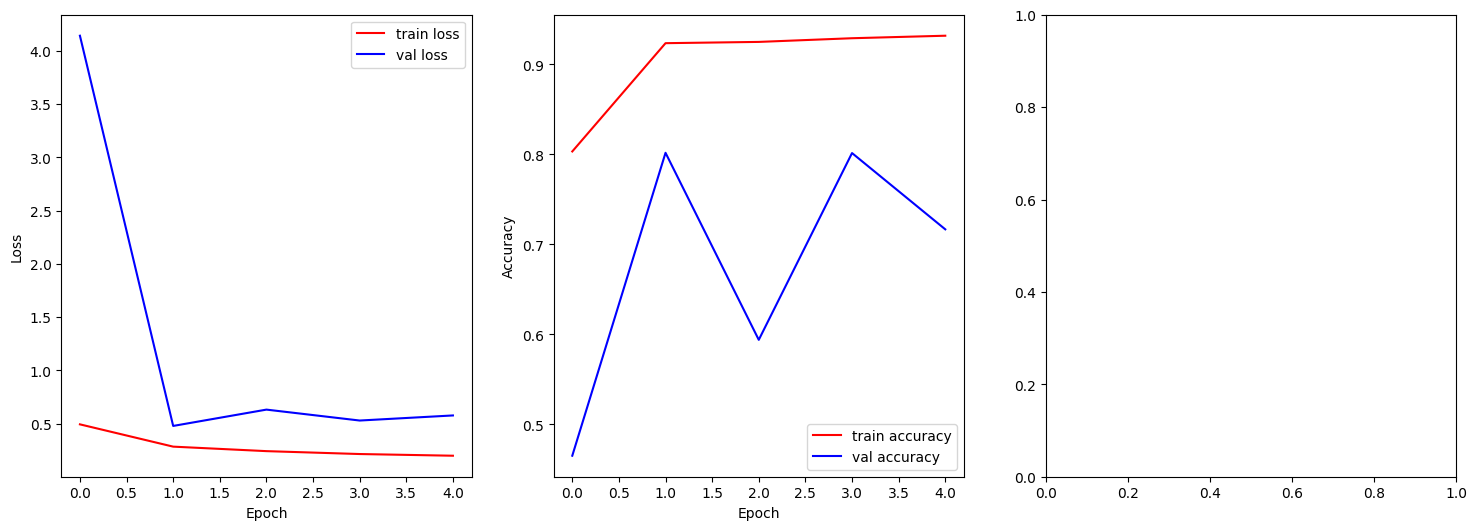

In [22]:
fig, ax = plt.subplots(figsize=(18, 6), nrows=1, ncols=3)
ax[0].plot(results.history["loss"], c="r", label="train loss")
ax[0].plot(results.history["val_loss"], c="b", label="val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(results.history["accuracy"], c="r", label="train accuracy")
ax[1].plot(results.history["val_accuracy"], c="b", label="val accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

Predicting on a Sample Image

1/1 [==============================] - 0s 195ms/step


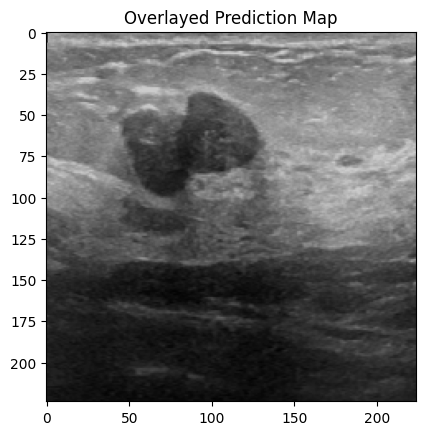

In [33]:
import cv2
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import numpy as np

r = random.randint(0, len(list(testd['images'])))
read_img = list(traind['images'])[r]

# load the image file
img = load_img(read_img, target_size=(224, 224))

# convert the image to a NumPy array
img_array = img_to_array(img)

# expand the dimensions of the array to match the expected input shape of the Keras model
input_data = np.expand_dims(img_array, axis=0)

# pass the input data to the Keras model for prediction
prediction = model.predict(input_data)
pred_image = prediction[0, :, :, 0]
pred_image_pil = Image.fromarray(pred_image)


plt.imshow(img, cmap='gray')
plt.imshow(pred_image_pil, alpha=0.2)
plt.show()
